In [5]:
import numpy as np
import math
import random
import os
import torch
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import torch.nn as nn
import torch.nn.functional as F


import trimesh

In [11]:
#set active device to 'cpu' or 'gpu', look for "torch.cuda.is_available()"
if(torch.cuda.is_available()):
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

cuda


In [12]:
#define hyper-parameters
num_points = 2048
num_classes = 7
batch_size = 50

In [13]:
import os
DATA_DIR = './ModelNet10'
print(os.listdir(DATA_DIR))

['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']


In [5]:
mesh = trimesh.load(os.path.join(DATA_DIR, 'night_stand/train/night_stand_0001.off'))
mesh.show()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


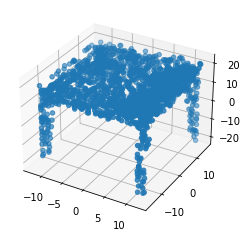

In [6]:
from matplotlib import pyplot as plt

#sample 2048 points from each model
nt_points = mesh.sample(num_points)
ax = plt.axes(projection = '3d')
ax.scatter(nt_points[:, 0], nt_points[:,1], nt_points[:, 2])
plt.show()

In [9]:
import glob

def parse_data(num_points = 2048):

    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    class_map = {}
    folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

    for i, folder in enumerate(folders):
        print("processing class: {}".format(os.path.basename(folder)))
        # store folder name with ID so we can retrieve later
        class_map[i] = folder.split("/")[-1]
        # gather all files
        train_files = glob.glob(os.path.join(folder, "train/*"))
        test_files = glob.glob(os.path.join(folder, "test/*"))

        for f in train_files:
            train_points.append(trimesh.load(f).sample(num_points))
            train_labels.append(i)

        for f in test_files:
            test_points.append(trimesh.load(f).sample(num_points))
            test_labels.append(i)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )

In [14]:
train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_data(num_points)

processing class: bathtub
processing class: bed
processing class: chair
processing class: night_stand
processing class: sofa
processing class: table
processing class: toilet


In [16]:
train_points = np.array(train_points)
test_points = np.array(test_points)
def Normalize(pointcloud):
    assert len(pointcloud.shape)==2

    norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
    norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

    return  norm_pointcloud

for i in range(len(train_points)):
    train_points[i] = Normalize(train_points[i])
for i in range(len(test_points)):
    test_points[i] = Normalize(test_points[i])
print(train_points[0])    

train_points = torch.as_tensor(train_points, dtype = float)
train_points = torch.transpose(train_points,1,2)
train_labels = torch.as_tensor(train_labels)
test_points = torch.as_tensor(test_points, dtype = float)
test_points = torch.transpose(test_points,1,2)
test_labels = torch.as_tensor(test_labels)
print(train_points.size())
torch.save(CLASS_MAP, 'classmap.pt')
torch.save(train_points, 'train_points.pt')
torch.save(test_points, 'test_points.pt')
torch.save(train_labels, 'train_labels.pt')
torch.save(test_labels, 'test_labels.pt')

[[ 0.12776571 -0.11562186  0.05445687]
 [-0.09411439 -0.60580467 -0.07165238]
 [ 0.24509219 -0.27959686 -0.18604521]
 ...
 [ 0.39407798  0.78447955 -0.46607023]
 [ 0.41494945 -0.53384987  0.39815934]
 [ 0.21884523  0.61185155 -0.32316957]]
torch.Size([3126, 3, 2048])


In [18]:
train_points = torch.load('train_points.pt')
test_points = torch.load('test_points.pt')
train_labels = torch.load('train_labels.pt')
test_labels = torch.load('test_labels.pt')
print(train_points.shape)
#CLASS_MAP = torch.load('classmap.pt')
idx = np.random.permutation(train_points.size(0))
train_points,train_labels = train_points[idx], train_labels[idx]

idx = np.random.permutation(test_points.size(0))
test_points,test_labels = test_points[idx], test_labels[idx]

print(train_labels)
print(test_labels)


torch.Size([3126, 3, 2048])
tensor([6, 2, 4,  ..., 4, 6, 3], dtype=torch.int32)
tensor([1, 4, 6, 1, 2, 2, 5, 6, 3, 3, 6, 3, 3, 1, 6, 4, 1, 3, 1, 5, 3, 5, 1, 6,
        0, 3, 4, 5, 5, 3, 3, 4, 5, 6, 4, 6, 6, 4, 6, 2, 3, 0, 5, 3, 2, 5, 3, 6,
        5, 2, 3, 2, 6, 5, 3, 0, 0, 0, 5, 1, 0, 2, 3, 4, 4, 4, 4, 1, 2, 3, 0, 0,
        0, 2, 1, 1, 1, 4, 6, 1, 6, 1, 1, 2, 2, 1, 6, 5, 4, 2, 4, 1, 5, 6, 5, 5,
        4, 3, 5, 3, 6, 0, 2, 1, 1, 2, 0, 3, 4, 3, 4, 3, 4, 6, 2, 0, 1, 4, 3, 1,
        2, 0, 5, 1, 4, 5, 4, 2, 2, 6, 2, 0, 3, 2, 6, 3, 1, 6, 6, 4, 4, 5, 6, 3,
        4, 4, 5, 4, 3, 4, 1, 2, 3, 2, 1, 5, 6, 0, 4, 5, 1, 2, 4, 1, 3, 5, 2, 6,
        6, 5, 3, 2, 5, 6, 2, 4, 6, 2, 5, 2, 2, 3, 3, 0, 1, 2, 6, 1, 4, 5, 5, 3,
        2, 1, 6, 2, 1, 3, 4, 1, 6, 0, 3, 6, 1, 3, 4, 5, 0, 1, 0, 6, 2, 3, 6, 1,
        1, 3, 2, 6, 1, 2, 3, 2, 5, 3, 3, 2, 3, 6, 1, 2, 6, 4, 3, 2, 4, 5, 1, 6,
        3, 5, 3, 1, 0, 3, 1, 1, 4, 6, 2, 5, 6, 2, 4, 1, 1, 3, 4, 3, 3, 4, 0, 1,
        5, 1, 2, 5, 0, 3, 4, 4, 0, 4, 0,

NameError: name 'CLASS_MAP' is not defined

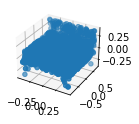

In [10]:
import matplotlib.pyplot as plt
points = train_points[:20].to(device)
labels = train_labels[:20].to(device)


points = points.to('cpu')
labels = labels.to('cpu')

points = np.array(points)
labels = np.array(torch.flatten(labels))
# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1, projection="3d")
    ax.scatter(points[i, 0, :], points[i, 1, :], points[i, 2, :])
    ax.set_title(CLASS_MAP[labels[i]][11:])
    ax.set_axis_off()
plt.show()

In [9]:
class TNet(nn.Module):
    def __init__(self, n_sample, n_feature):
        super(TNet, self).__init__()
        self.n_sample = n_sample
        self.n_feature = n_feature
        
        self.mlp1 = nn.Sequential(
            nn.Conv1d(n_feature, 64, kernel_size = 1),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(True),
            nn.Conv1d(64, 128, kernel_size = 1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(True),
            nn.Conv1d(128, 1024, kernel_size = 1),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(True)
            
        )
        


        self.mlp2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(512),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(256),
            nn.Linear(256, n_feature * n_feature)
        )

    def forward(self, x):
      x = x.float()
      input = x
      x = self.mlp1(x)
      x = nn.MaxPool1d(self.n_sample)(x)
      x = torch.flatten(x, start_dim = 1)
      x = self.mlp2(x)
      x = x.reshape((x.size(0), self.n_feature, self.n_feature))
      x = x @ input
      return x

In [10]:
class PointNet(nn.Module):
  def __init__(self, n_sample, n_classes):
      super(PointNet, self).__init__()
        
      self.n_sample = n_sample
    
      self.mlp64 = nn.Sequential(
          nn.Conv1d(3, 64, kernel_size = 1),
          nn.BatchNorm1d(64),
          nn.ReLU(True),
      )

      self.mlp1024 = nn.Sequential(
          nn.Conv1d(64, 128, kernel_size = 1),
          nn.BatchNorm1d(128),
          nn.LeakyReLU(True),
          nn.Conv1d(128, 1024, kernel_size = 1),
          nn.BatchNorm1d(1024),
          nn.LeakyReLU(True)
      )

      self.mlpk = nn.Sequential(
          nn.Linear(1024, 512),
          nn.BatchNorm1d(512),
          nn.LeakyReLU(True),
          nn.Linear(512, 256),
          nn.BatchNorm1d(256),
          nn.LeakyReLU(True),
          nn.Linear(256, n_classes),
          nn.Softmax(dim = -1)
      )

      self.t3 = TNet(n_sample, 3)

      self.t64 = TNet(n_sample, 64)

      self.fc1 = nn.Sequential(nn.Linear(1088, 512))
      self.fc2 = nn.Sequential(nn.Linear(512, 256))
      self.fc3 = nn.Sequential(nn.Linear(256, 128))
      self.fc4 = nn.Sequential(nn.Linear(128, 128)) #here we choose 10 features
      
      self.bn1 = nn.Sequential(nn.BatchNorm1d(512))
      self.bn2 = nn.Sequential(nn.BatchNorm1d(256))
      self.bn3 = nn.Sequential(nn.BatchNorm1d(128))
    
  def forward2(self, x):

    x = x.float()
    x = self.t3.forward(x)
    x = self.mlp64(x)
    x = self.t64.forward(x)
    
    feat_map64 = x
    
    x = self.mlp1024(x)
    x = nn.MaxPool1d(self.n_sample)(x)
    x = torch.flatten(x, start_dim = 1)
    
    glob_feat = x
    
    x = self.mlpk(x)
    
    glob_feat = torch.unsqueeze(glob_feat, -1)
    glob_feat = glob_feat.repeat(1, 1, self.n_sample)
    feat_map = torch.cat((feat_map64, glob_feat), dim = 1)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc1(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn1(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc2(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn2(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc3(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.bn3(feat_map)
    feat_map = feat_map.transpose(1,2)
    feat_map = self.fc4(feat_map)
    return x, feat_map



In [11]:
pointnet = PointNet(2048, num_classes)
pointnet.to(device)

PointNet(
  (mlp64): Sequential(
    (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mlp1024): Sequential(
    (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
    (4): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=True)
  )
  (mlpk): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=True)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(ne

In [12]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

In [13]:
def training(train_points,train_labels, device, optimizer, test_points, test_labels):
# Set our network to the training model.
    pointnet.train()
# Init the train loss, total data and number corrected predictions.
    train_loss = 0
    total_data = 0
    prediction = 0
    data_size1 = 0
    num_corr_predictions1 = 0
    total_datasize1 = 0
    

# For each data in the training split
    for i in range(0,len(train_labels) - batch_size, batch_size):
        data = train_points[i:i+batch_size]
        value = train_labels[i:i+batch_size].long()
        corr_pred1 = 0
# Put the data to the correct devices using .to()
        data = data.to(device)
        value = value.to(device)
        
# Reset the gradient of the optimzier.
        optimizer.zero_grad()      
# Feed the data forward to the google net
        forwarded_data = pointnet.forward2(data)[0]
# Use the criterion function to compute the loss term
        loss = criterion(forwarded_data, value)
        #print('loss is', loss)

# Backprop the loss
        loss.backward()
    
        # Update the network parameters using the optimzier
        # try optimizer.step(closure) from https://pytorch.org/docs/stable/optim.html
        optimizer.step()
    
        # Accumulate the training loss
        train_loss += loss.item()
    

# Find the prediciton. hint: using torch.max() 

        max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
        prediction = max_idxs 
        
# Increment the data size
        data_size = value.size(0)
        total_datasize1 += data_size
#     # Increment the corrected prediction
        for i in range(data_size):
            if prediction[i]==value[i]:
                num_corr_predictions1 += 1
        
    
                
    
##     TESTING   
# Set our network to the test model.
    pointnet.eval()
    # Init the 
    test_loss = 0
    total_data = 0 
    num_corr_predictions = 0
    
    data_size = 0
    total_datasize = 0
    Pred_test = 0

    # For each data in the training split, we warp it using torch.no_grad()

    with torch.no_grad():        
        for i in range(0,len(test_labels) - batch_size, batch_size):
            data = test_points[i: i + batch_size]
            value = test_labels[i:i + batch_size].long()
            
    # Put the data to the correct devices using .to()
            data = data.to(device)
            value = value.to(device)

    # Feed the data forward to the google net
            forwarded_data = pointnet.forward2(data)[0]

    # Use the criterion function to compute the loss term
            loss = criterion(forwarded_data, value)
            
    # Accumulate the testing loss
            test_loss += loss.item()
            
    # Find the prediciton. hint: using torch.max()
            max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
            prediction = max_idxs


#     Increment the data size
            data_size = value.size(0)
            total_datasize += data_size
#     # Increment the corrected prediction
            corr_pred = 0
            for i in range(data_size):
                if prediction[i]==value[i]:
                    #increment number of correct predictions (corr_pred)
                    corr_pred += 1
            #increment num_corr_predictions by corr_pred
            num_corr_predictions += corr_pred

    training_acc = num_corr_predictions1/total_datasize1

    testing_acc = num_corr_predictions/total_datasize

    return training_acc, testing_acc, train_loss, test_loss



In [14]:
#Train and Test the DNN model

AllTestAcc = []
AllTrainAcc = []
LossTrain = []
LossTest = []

epoches = 10 #change to 25 later
# For each epoch:
for ep in range(epoches):

# we train and test our module
    training_acc, testing_acc, train_loss, test_loss = training(train_points, train_labels, device, optimizer, test_points, test_labels)
# we update the testing accuracy
    AllTestAcc.append(testing_acc)
    AllTrainAcc.append(training_acc)
    LossTrain.append(train_loss)
    LossTest.append(test_loss)
    
    training_acc = training_acc*100
    testing_acc = testing_acc*100
    print('Epoch ',ep)
    print('Training accuracy is:', ("%.4g" % training_acc) ,'%, ', 'Testing accuracy:', ("%.4g" % testing_acc),'%')
    
    print('Training loss is:', train_loss , 'Testing loss is:',test_loss)
# we save the module at the end and print the accuracy
# we first step our scheduler
    scheduler.step()

Epoch  0
Training accuracy is: 74.55 %,  Testing accuracy: 65.33 %
Training loss is: 88.20642328262329 Testing loss is: 18.112747192382812
Epoch  1
Training accuracy is: 82.26 %,  Testing accuracy: 66.17 %
Training loss is: 83.15808522701263 Testing loss is: 17.977911114692688
Epoch  2
Training accuracy is: 83.45 %,  Testing accuracy: 60.5 %
Training loss is: 82.3901596069336 Testing loss is: 18.5478435754776
Epoch  3
Training accuracy is: 87.23 %,  Testing accuracy: 76 %
Training loss is: 80.31782901287079 Testing loss is: 16.87496280670166
Epoch  4
Training accuracy is: 88.13 %,  Testing accuracy: 66.17 %
Training loss is: 79.51651120185852 Testing loss is: 17.944563388824463
Epoch  5
Training accuracy is: 85.94 %,  Testing accuracy: 80.17 %
Training loss is: 81.03124463558197 Testing loss is: 16.348307251930237
Epoch  6
Training accuracy is: 89.52 %,  Testing accuracy: 60.33 %
Training loss is: 78.77886915206909 Testing loss is: 18.728041887283325
Epoch  7
Training accuracy is: 88.5

In [18]:
points = train_points[:20].to(device)
labels = train_labels[:20].to(device)
forwarded_data, feat_map = pointnet.forward2(points)
max_elements, max_idxs = torch.max(forwarded_data, dim = 1)
preds = max_idxs
print(preds)
print(labels)

tensor([4, 6, 5, 4, 6, 2, 2, 4, 2, 6, 1, 2, 1, 6, 5, 2, 3, 4, 2, 4],
       device='cuda:0')
tensor([0, 2, 5, 4, 2, 2, 2, 3, 2, 6, 1, 2, 1, 6, 6, 6, 3, 4, 2, 4],
       device='cuda:0', dtype=torch.int32)


torch.Size([20, 2048])
tensor([[121, 114,  68,  ...,  45, 103, 103],
        [ 74,  74,  50,  ..., 119,  74,  74],
        [ 57,  57,  69,  ...,  57,  57,  57],
        ...,
        [  9,  23,  97,  ...,  97,  23,  97],
        [115,  83,  83,  ..., 116,   5, 116],
        [ 23, 121,  42,  ...,  97, 121,  23]], device='cuda:0')


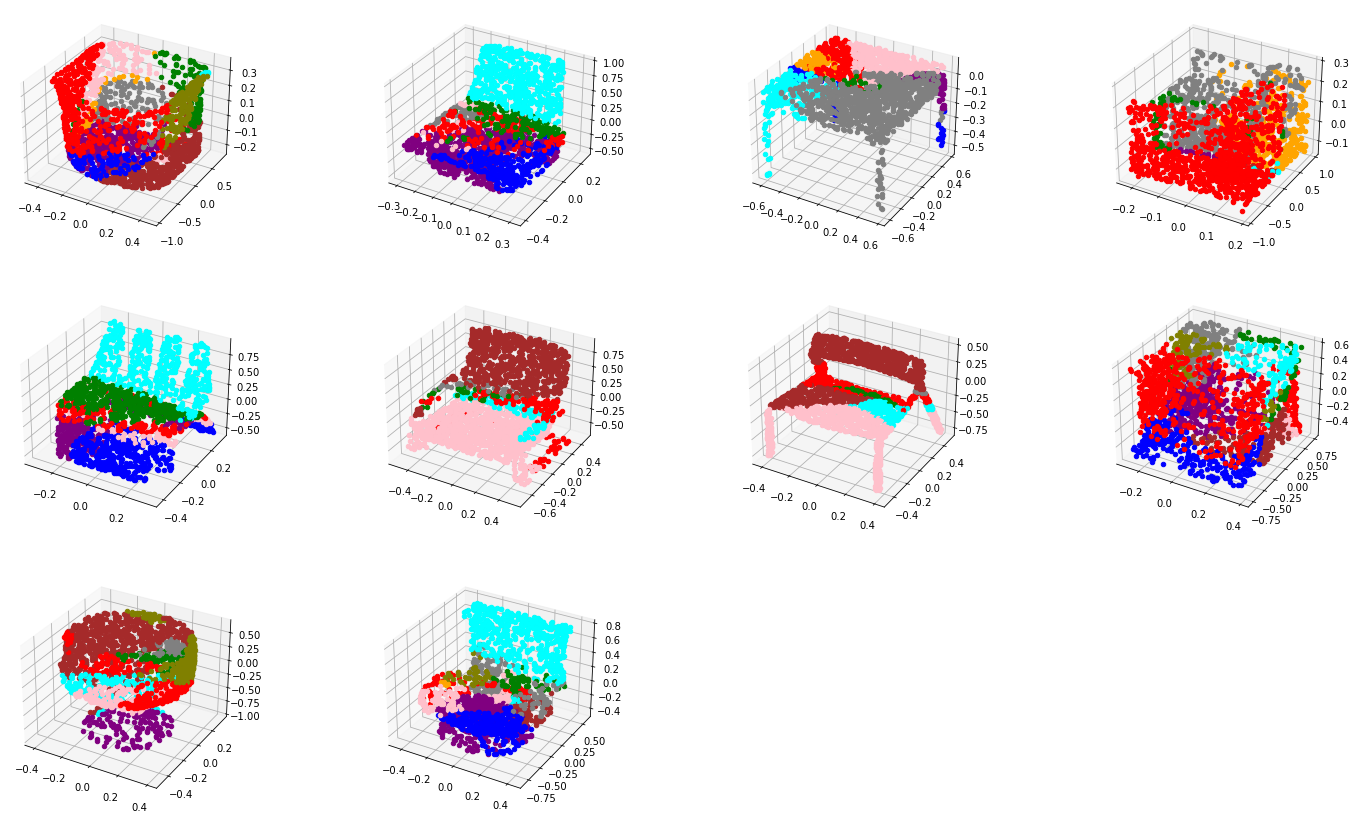

In [19]:

points = points.to('cpu').numpy()
preds = preds.to('cpu')
labels = labels.to('cpu')


max_elements, max_idxs = torch.max(feat_map, dim = 2)
seg_points = max_idxs
print(seg_points.size())
print(seg_points)
color = ['blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan','blue','orange','green','red','purple','brown','pink','gray','olive','cyan']
obj = points[0]

fig = plt.figure(figsize=(25, 25))
for j in range(10):
    obj = points[j]
    ax = fig.add_subplot(5, 4, j + 1, projection="3d")
    for i in range(2048):
        ax.scatter(obj[0][i], obj[1][i], obj[2][i], color = color[seg_points[j][i]])

plt.show()

NameError: name 'CLASS_MAP' is not defined

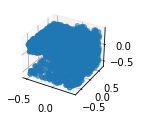

In [16]:
'''
points = points.to('cpu').numpy()
preds = preds.to('cpu')
labels = labels.to('cpu')
'''

preds = np.array(preds)
labels = np.array(labels)
# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(20):
    ax = fig.add_subplot(5, 4, i + 1, projection="3d")
    ax.scatter(points[i, 0, :], points[i, 1, :], points[i, 2, :])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i]], CLASS_MAP[labels[i]]
        )
    )
    ax.set_axis_off()
plt.show()